In [303]:
%reload_ext autoreload
%autoreload 2

from collections import Counter
import numpy as np
import pandas as pd
from app import Preprocessing

from matplotlib import pyplot as plt
import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")

%load_ext Cython

In [152]:
pre = Preprocessing('IMDB')

In [184]:
pre.load_data(name='IMDB')

In [185]:
pre.data['Train'].head()

,text,filename,POS__NEG
0,"I did not expect much from this film, but boy-...",3703_3.txt,0
1,First off there is nothing wrong with studying...,3730_2.txt,0
2,Whenever a Columbo story deviates from the fam...,766_4.txt,0
3,"This movie rivals ""Plan 9"" as one of the dumbe...",7249_1.txt,0
4,Worst movie I have seen since Gingerale Aftern...,10889_1.txt,0


In [186]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [187]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
word1=''
for i in range(pre.data['Train'].shape[0]):
    if(pre.data['Train']['POS__NEG'][i] == 1):
        for word in pre.data['Train']['text'][i].split(" "):
            word2=word
            positive_counts[word1+' '+word2] += 1
            total_counts[word1+' '+word2] += 1
            word1=word2
    else:
        for word in pre.data['Train']['text'][i].split(" "):
            word2=word
            negative_counts[word1+' '+word2] += 1
            total_counts[word1+' '+word2] += 1
            word1=word2

In [188]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [189]:
drop_count=0
drop_words = []

# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)
    if pos_neg_ratios[word]>-0.95 and pos_neg_ratios[word]<0.95:
        drop_words.append(word)
        drop_count+=1

In [190]:
len(list(drop_words))

4407

In [191]:
len(list(pos_neg_ratios))

4755

In [192]:
listx = pos_neg_ratios.copy()

In [193]:
for dword in drop_words:
    del listx[dword]

In [194]:
len(list(listx))

348

In [195]:
word_list = dict(listx)

In [196]:
count = 0
for key,idx in word_list.items():
    word_list[key]=count
    count+=1

In [197]:
data=np.zeros((pre.data['Train'].shape[0], len(word_list)))

word1=''
for i in range(pre.data['Train'].shape[0]):    
     for word in pre.data['Train']['text'][i].split(" "):
            word2=word
            if word1+' '+word2 in word_list:
                data[i][word_list[word1+' '+word2]]+=word_list[word1+' '+word2]
            word1=word2


In [198]:
data

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., 345.,   0.,   0.]])

In [199]:
data.shape

(25000, 348)

In [200]:
pre.set('Train_raw', pre.data['Train'])

In [202]:
pre.set('Train', pd.DataFrame(data, columns=word_list))
pre.data['Train'].describe()

,the best,the worst,supposed to,a bad,looks like,not even,bunch of,waste of,at all.,minutes of,...,drama and,bad for,can't wait,about any,gore and,delivers a,well done.,why did,any real,the gore
count,25000.0,25000.0000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.0,0.0706,0.10576,0.129960,0.117120,0.140600,0.163680,0.188440,0.204480,0.218880,...,1.379040,1.383120,1.387200,1.391280,1.395360,1.38572,1.389760,1.393800,1.397840,1.401880
std,0.0,0.2911,0.52462,0.679389,0.750723,0.863285,1.079618,1.229224,1.346945,1.485672,...,22.173227,21.609797,22.096136,21.950229,22.435632,22.18615,22.037067,22.946664,22.380198,22.870044
min,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,0.0,5.0000,10.00000,18.000000,20.000000,15.000000,30.000000,35.000000,32.000000,36.000000,...,676.000000,339.000000,680.000000,682.000000,684.000000,686.00000,688.000000,690.000000,692.000000,694.000000


In [203]:
data_test=np.zeros((pre.data['Test'].shape[0], len(word_list)))

word1=''
for i in range(pre.data['Test'].shape[0]):    
     for word in pre.data['Test']['text'][i].split(" "):
            word2=word
            if word1+' '+word2 in word_list:
                data_test[i][word_list[word1+' '+word2]]+=word_list[word1+' '+word2]
            word1=word2

In [204]:
pre.set('Test_raw', pre.data['Test'])

In [206]:
pre.set('Test', pd.DataFrame(data_test, columns=word_list))
pre.data['Test'].describe()

,the best,the worst,supposed to,a bad,looks like,not even,bunch of,waste of,at all.,minutes of,...,drama and,bad for,can't wait,about any,gore and,delivers a,well done.,why did,any real,the gore
count,25000.0,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.00000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,0.0,0.068240,0.090880,0.121920,0.112800,0.139600,0.162480,0.184800,0.197440,0.221400,...,1.06808,1.220400,0.992800,1.200320,1.08072,1.234800,1.293440,1.559400,1.550080,1.44352
std,0.0,0.290494,0.467236,0.641959,0.710673,0.881217,1.053473,1.217764,1.319199,1.505879,...,19.44645,20.751646,18.346112,20.425169,19.19513,20.996503,21.718423,23.751839,24.515096,23.59314
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
max,0.0,6.000000,8.000000,18.000000,16.000000,15.000000,24.000000,35.000000,24.000000,54.000000,...,676.00000,678.000000,340.000000,682.000000,342.00000,686.000000,688.000000,690.000000,1038.000000,694.00000


In [182]:
pre.data['Test'].describe()

,the best,the worst,supposed to,a bad,looks like,not even,bunch of,waste of,at all.,minutes of,...,the script.,about any,whom he,can't wait,running around,well done.,any real,delivers a,why did,the gore
count,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,...,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [430]:
x_test = torch.tensor(pre.data['Test'].values).float()
y_test = torch.tensor(pre.get('Test_raw')['POS__NEG'].values).long()

In [431]:
x = torch.tensor(pre.data['Train'].values).float()
y = torch.tensor(pre.get('Train_raw')['POS__NEG'].values).long()

In [436]:
# Logistic regression model
model = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 2)#,
    #torch.nn.Sigmoid()
)

In [437]:
# Hyper-parameters 
learning_rate = 0.001

In [438]:
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally

criterion = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [439]:
loss_hist = []
# Train
for t in range(1000):
    # Berechne die Vorhersage (foward step)
    outputs = model(x)
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 50 Iterationen)
    loss = criterion(outputs, y)
    
    # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    if t % 10 == 0:
        loss_hist.append(loss.item())
        #print(t, loss.item())

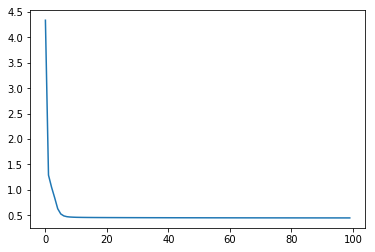

In [440]:
plt.plot(loss_hist);

In [441]:
outputs_test = model(x_test)
#loss = criterion(outputs_test, y_test)
#loss

tensor(0.4706, grad_fn=<NllLossBackward>)

In [446]:
agg_model = nn.Softmax()

In [487]:
y_test_pred_sm = agg_model(outputs_test).argmax(1)

/Users/cm/anaconda3/envs/imdb/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [489]:
# Klassifikationsgenauigkeit
classification_accuracy_test =(y_test.float() == y_test_pred_sm.float()).float().mean()
classification_accuracy_test

tensor(0.7749)

# Forest classifier

In [400]:
RandomForestClassifier?

In [287]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [288]:
X_train, X_val, y_train, y_val = train_test_split(x.numpy(), y.numpy(), test_size = 0.25)

In [407]:
error_train = []
error_val = []
auc_val = []
auc_train = []

for i in range(1, 30):
    for j in range(1,50):
        for k in range(2,50):
            d_forest = RandomForestClassifier(
            n_estimators=i,
            criterion='gini',
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_impurity_split=None,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=None,
            verbose=0,
            warm_start=False,
            class_weight=None,
            )
    d_forest.fit(X_train, y_train)
    y_pred_prob_train = d_forest.predict_proba(X_train)
    y_pred_prob_val = d_forest.predict_proba(X_val)
    error_train.append(metrics.mean_squared_error(y_train, y_pred_prob_train[:,1]))
    error_val.append(metrics.mean_squared_error(y_val, y_pred_prob_val[:,1]))

    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob_train[:,1])
    auc_train.append(metrics.auc(fpr, tpr))

    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_prob_val[:,1])
    auc_val.append(metrics.auc(fpr, tpr))

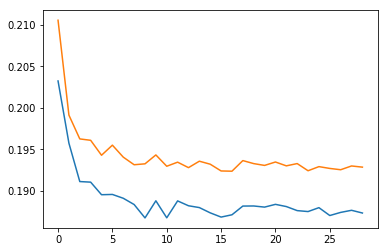

In [408]:
plt.plot(error_train)
plt.plot(error_val)

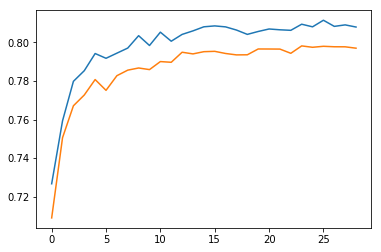

In [409]:
plt.plot(auc_train)
plt.plot(auc_val)

In [412]:
auc_val.index(max(auc_val))

23

In [410]:
error_val.index(min(error_val))

16

In [411]:
d_forest = RandomForestClassifier(n_estimators=24)

In [390]:
d_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [391]:
y_pred_test = d_forest.predict(x_test)
y_pred_prob_test = d_forest.predict_proba(x_test)

In [392]:
x_test.shape

torch.Size([25000, 348])

In [393]:
y_test.shape

torch.Size([25000])

In [394]:
y_pred_prob_test.shape

(25000, 2)

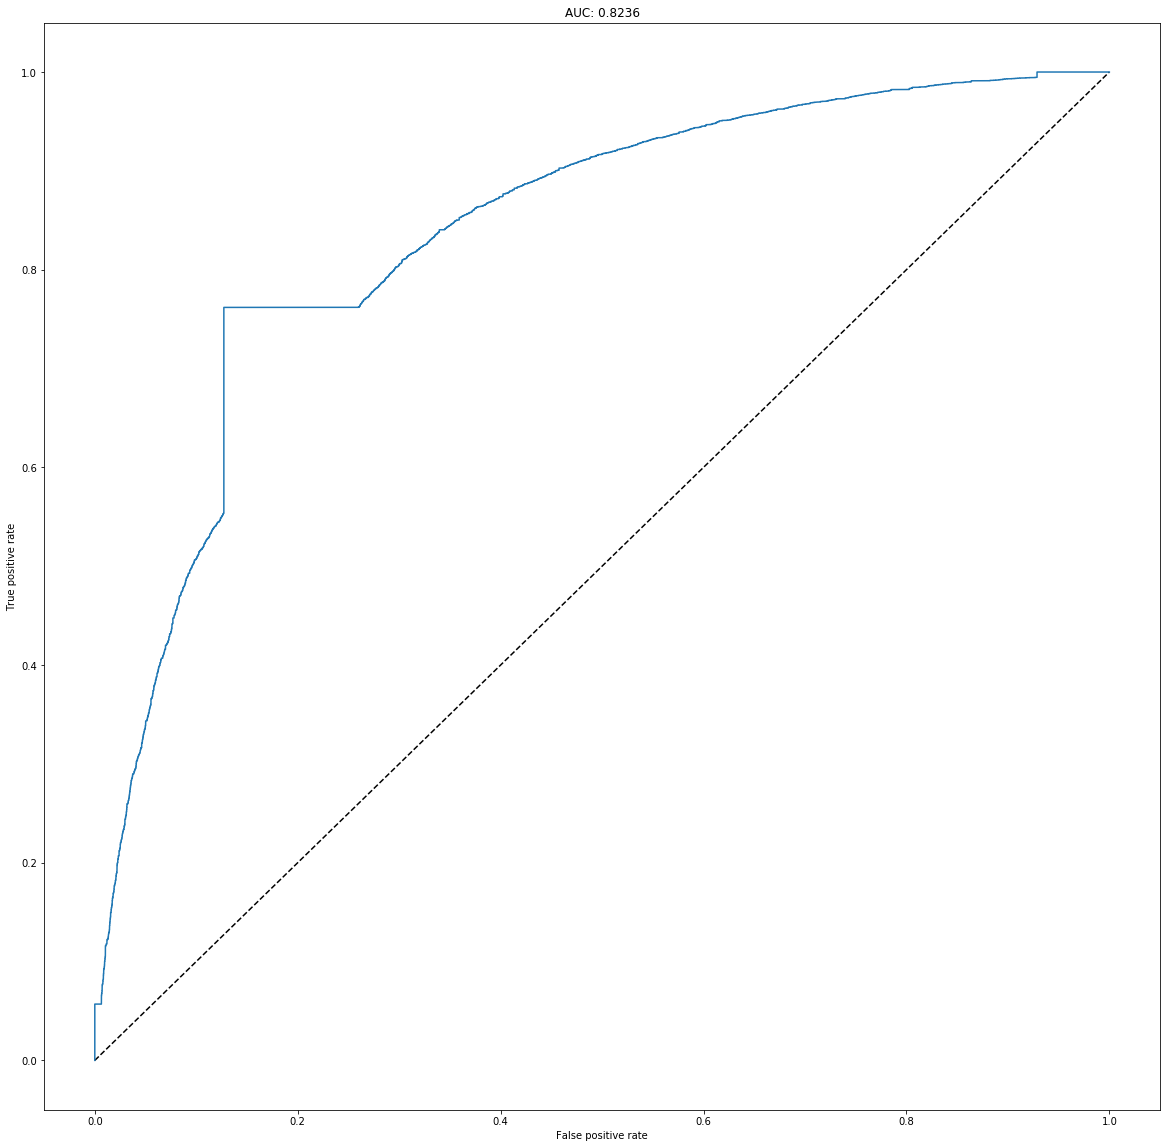

In [413]:
plt.figure(1, figsize=(20,20))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test[:,1])
auc = metrics.auc(fpr, tpr)
plt.title('AUC: ' + str(round(auc,4)))
plt.step(fpr, tpr)

plt.show()

In [414]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test[:,1])

In [415]:
pd_eval = pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':thresholds})

In [416]:
# Klassifikationsgenauigkeit
classification_accuracy_test = 1 * (y_test.numpy() == y_pred_test).mean()
classification_accuracy_test

0.7526

In [417]:
# Testdatensatz
missclassification_test = 1 * (y_test.numpy() != y_pred_test).mean()
missclassification_test

0.2474

# 